In [1]:
from meta_kg.utils.py_io import *

# dynamic = read_json("./output/20221124-010221/dev_out-epoch=0_step=11250.json")
# dynamic = read_json("./output/20221129-195134/dev_out-epoch=0_step=11250.json")
dynamic = read_json("./output/20221205-051520/dev_out-epoch=0_step=3600.json")

inner_loss_token_dynamic = []
topk_tokens_dynamic = []
inner_loss_dynamic = []
for log in dynamic:
    inner_loss = log["inner_loss"]
    topk_tokens = log["topk_tokens"]
    inner_loss_token = log["inner_loss_token"]
    inner_loss_dynamic.append(inner_loss)
    topk_tokens_dynamic.append(topk_tokens)
    inner_loss_token_dynamic.append(inner_loss_token)

inner_loss_token_dynamic[0]

[{'4: C': [-0.0, -4.1407790184021],
  '5: K': [-0.0, -10.682438850402832],
  '6: sister': [-0.0, -5.330160140991211]},
 {'4: Z': [-0.0, -19.110092163085938],
  '5: C': [-0.0, -12.956228256225586],
  '6: son': [-0.0, -4.36173677444458]}]

In [24]:
gen_outs = [' '.join(out['gen_out'].split()[1:4]) for out in dynamic]
answers = [out['answer'] for out in dynamic]

In [25]:
acc = 0
for i in range(len(gen_outs)):
    if gen_outs[i] == answers[i]:
        acc += 1
acc / len(gen_outs)

0.9996

/tmp/ipykernel_38048/2871631813.py:9: RuntimeWarning: invalid value encountered in true_divide
  def rescale(y): return (y - np.min(y)) / (np.max(y) - np.min(y))


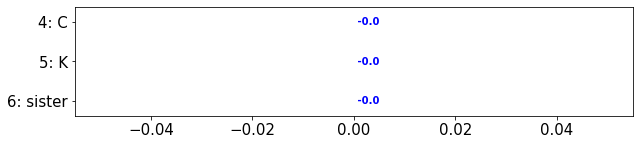

/tmp/ipykernel_38048/2871631813.py:9: RuntimeWarning: invalid value encountered in true_divide
  def rescale(y): return (y - np.min(y)) / (np.max(y) - np.min(y))


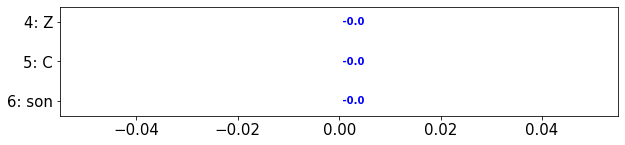

/tmp/ipykernel_38048/2871631813.py:9: RuntimeWarning: invalid value encountered in true_divide
  def rescale(y): return (y - np.min(y)) / (np.max(y) - np.min(y))


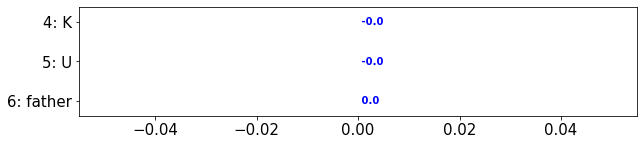

/tmp/ipykernel_38048/2871631813.py:9: RuntimeWarning: invalid value encountered in true_divide
  def rescale(y): return (y - np.min(y)) / (np.max(y) - np.min(y))


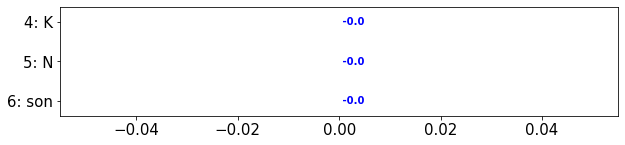

In [2]:
import numpy as np
import matplotlib.pyplot as plt

index = 0


def plot_loss_token(inner_loss_token, index):
    plasma = plt.get_cmap('tab20c')
    def rescale(y): return (y - np.min(y)) / (np.max(y) - np.min(y))

    for token_loss in inner_loss_token:
        tokens = [tok for tok in list(token_loss.keys())]
        tokens.reverse()
        losses = [round(loss[0], 3) for loss in list(token_loss.values())]
        losses.reverse()

        plt.figure(figsize=(10, 2))
        plt.barh(tokens, losses, color=plasma(rescale(losses)), height=0.5)
        plt.xticks(rotation=0, fontsize=15)
        plt.yticks(rotation=0, fontsize=15)
        for i, v in enumerate(losses):
            plt.text(v, i, " "+str(v), color='blue',
                     va='center', fontweight='bold')

        # plt.savefig(f'./output/token_loss_{index}.png', bbox_inches='tight', dpi=300)
        index += 1
        plt.show()


plot_loss_token(inner_loss_token_dynamic[0], index)
plot_loss_token(inner_loss_token_dynamic[10], index)


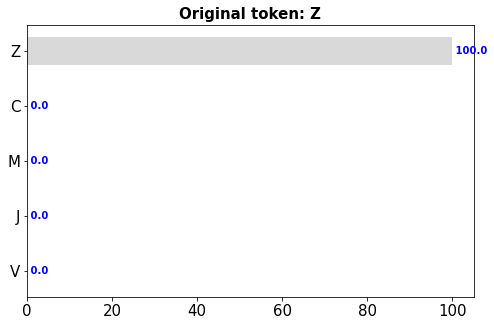

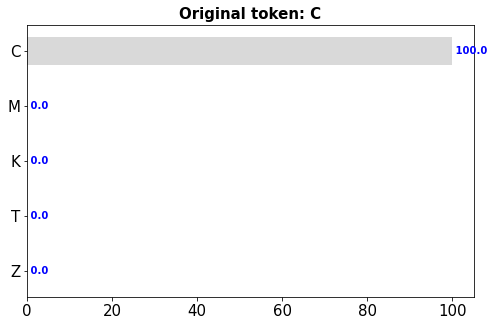

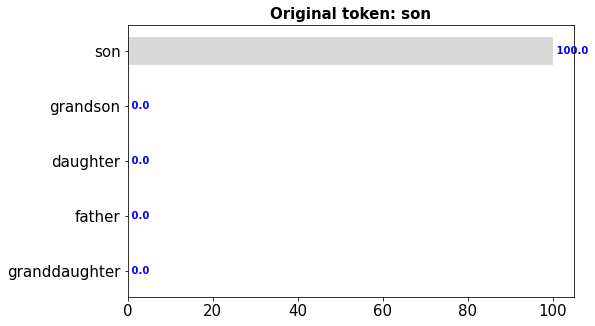

In [3]:
def plot_topk_token(topk_tokens, index):
    plasma = plt.get_cmap('tab20c')
    def rescale(y): return (y - np.min(y)) / (np.max(y) - np.min(y))

    for record in topk_tokens:
        orig = record[0][0]
        tokens = [tok[1] for tok in record[:5]]
        probs = [tok[2] for tok in record[:5]]

        assert(len(tokens) == len(probs))

        tokens.reverse()
        probs.reverse()
        # print(tokens)
        # print(probs)

        plt.figure(figsize=(8, 5))
        plt.barh(tokens, probs, color=plasma(rescale(probs)), height=0.5)
        plt.xticks(rotation=0, fontsize=15)
        plt.yticks(rotation=0, fontsize=15)
        plt.title(f"Original token: {orig}", fontsize=15, fontweight='bold')
        for i, v in enumerate(probs):
            plt.text(v, i, " "+str(v), color='blue',
                     va='center', fontweight='bold')
        # plt.savefig(f'./output/token_loss_{index}.png', bbox_inches='tight', dpi=300)
        index += 1
        plt.show()


index = 0
plot_topk_token(topk_tokens_dynamic[0][1], index)


In [4]:
all_loss = []
for inner_loss_token in inner_loss_token_dynamic[:1000]:
    for token_loss in inner_loss_token:
        losses = [loss[0] for loss in list(token_loss.values())[1:]]
        for loss in losses:
            all_loss.append(loss)
all_loss = np.array(all_loss)
q25, q75 = np.percentile(all_loss, [25, 75])
bin_width = 2 * (q75 - q25) * len(all_loss) ** (-1/3)
bins = round((all_loss.max() - all_loss.min()) / bin_width)
plt.figure(figsize=(6, 4))
plt.hist(all_loss, density=False, bins=bins)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Ratio')
plt.xlabel('Loss')

/tmp/ipykernel_38048/908390761.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  bins = round((all_loss.max() - all_loss.min()) / bin_width)


OverflowError: cannot convert float infinity to integer

Text(0.5, 0, 'Loss Difference')

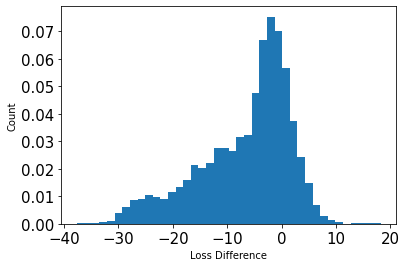

In [19]:
all_loss_diff = []
for inner_loss_token in inner_loss_token_dynamic[:1000]:
    for token_loss in inner_loss_token:
        losses = [loss[1] for loss in list(token_loss.values())[1:]]
        for loss in losses:
            all_loss_diff.append(loss)
all_loss_diff = np.array(all_loss_diff)
q25, q75 = np.percentile(all_loss_diff, [25, 75])
bin_width = 2 * (q75 - q25) * len(all_loss_diff) ** (-1/3)
bins = round((all_loss_diff.max() - all_loss_diff.min()) / bin_width)
plt.figure(figsize=(6, 4))
plt.hist(all_loss_diff, density=True, bins=bins)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Count')
plt.xlabel('Loss Difference')


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

hist, xedges, yedges = np.histogram2d(
    all_loss, all_loss_diff, bins=10, range=[[0, 10], [-5, 5]])

xedges = [round(x) for x in xedges]
yedges = [round(y) for y in yedges]

cmap = sns.cm.rocket_r
fig = plt.figure(figsize=(12, 8))
ax = sns.heatmap(
        hist, linewidth=0.8, cmap=cmap,
        xticklabels=xedges[:-1], yticklabels=yedges[:-1])
plt.show()

NameError: name 'all_loss_diff' is not defined

In [36]:
from meta_kg.utils.py_io import *

clutrr_train = read_jsonl('./data/clutrr_simple/train.jsonl')

In [37]:
clutrr_train[0]

{'guid': 'cee11a1b-6f53-40f2-b7fe-ce1361f203e1',
 'facts': [['C K', 'sister'], ['Z C', 'son']],
 'questions': [['How is Z related to K ?', 'Z K', 'nephew']],
 'proofs': ['since person 20 is a son to person 3 , and person 3 is a sister to person 6 , then person 20 is a nephew to person 6 .']}

In [41]:
from collections import Counter

relation_inner = [fact[1] for data in clutrr_train for fact in data['facts']]
Counter(relation_inner).most_common(10)


[('daughter', 26195),
 ('son', 26179),
 ('sister', 25008),
 ('brother', 24930),
 ('father', 19150),
 ('mother', 19149),
 ('husband', 10238),
 ('wife', 10224),
 ('granddaughter', 6385),
 ('grandfather', 6361)]

In [42]:
relation_outer = [q[2] for data in clutrr_train for q in data['questions']]
Counter(relation_outer).most_common(10)

[('sister', 9567),
 ('granddaughter', 9560),
 ('brother', 9556),
 ('grandson', 9165),
 ('grandfather', 6386),
 ('father', 6363),
 ('mother', 6360),
 ('grandmother', 5896),
 ('daughter', 5473),
 ('son', 5385)]

In [1]:
import torch

checkpoint = "./output/20221205-051520/epoch=0-step=7200.ckpt"

model = torch.load(checkpoint)

In [2]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt = GPT2LMHeadModel.from_pretrained('gpt2')

In [17]:
input_text = ["fact 1 123: ", "fact 2 123: ", "fact 3 123: "]
input_ids = tokenizer("fact 1 123: 1sddfgtg ", return_tensors='pt').input_ids

outputs = gpt.generate(input_ids, max_length=20, num_beams=5, do_sample=False, top_k=5, top_p=None, num_return_sequences=1)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [19]:
input_ids.size(1)

11

In [3]:
gpt2_param = gpt.state_dict()
for param in model['state_dict']:
    if "model.model" in param:
        new_param = param.replace("model.model", "")
        gpt2_param[new_param] = model['state_dict'][param]

In [9]:
[tokenizer.decode(out, skip_special_tokens=True) for out in outputs]

['fact 1: 𝒞𝒞𝒞𝒞𝒞�',
 'fact 2: 𝒞𝒞𝒞𝒞𝒞�',
 "fact 3: \xa0I don't know what to say about it, but I think it's"]